In [72]:
# ========================
# 📦 Import Libraries
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.base import clone
from collections import Counter
import pickle
import warnings
warnings.filterwarnings("ignore")


In [73]:
#%pip install kagglehub
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("itachi9604/disease-symptom-description-dataset")

#print("Path to dataset files:", path)
data1= pd.read_csv('dataset.csv')
data2=pd.read_csv('symptom_Description.csv')
data3=pd.read_csv('symptom_precaution.csv')
data4=pd.read_csv('Symptom-severity.csv')

data1.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Fungal infection,vomiting,vomiting,fatigue,high_fever,headache,nausea,abdominal_pain,abdominal_pain,yellowing_of_eyes,yellowing_of_eyes,irritability,malaise,muscle_pain,chest_pain,chest_pain,blood_in_sputum,muscle_pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


In [74]:
data2.head()

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


In [75]:
data4.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [76]:
# ========================
# 📂 Load Datasets
# ========================
# Make sure to update paths accordingly
df = pd.read_csv("dataset.csv").fillna("")
severity_df = pd.read_csv("Symptom-severity.csv")
precaution_df = pd.read_csv("symptom_precaution.csv").fillna("")



In [77]:
# ========================
# 🧹 Data Cleaning
# ========================
# Clean columns
severity_df.columns = severity_df.columns.str.strip().str.replace('\ufeff', '')
precaution_df.columns = precaution_df.columns.str.strip().str.replace('\ufeff', '')


In [78]:
# Create dictionaries
symptom_severity = dict(zip(severity_df['Symptom'].str.lower().str.strip(), severity_df['weight']))
precaution_dict = {row["Disease"]: [row["Precaution_1"], row["Precaution_2"], row["Precaution_3"], row["Precaution_4"]] 
                   for _, row in precaution_df.iterrows()}

In [79]:
# ========================
# 🧹 Prepare One-Hot Encoding Data
# ========================
all_symptoms = sorted(set(symptom.lower().strip() 
                          for col in df.columns[1:] 
                          for symptom in df[col].unique() 
                          if pd.notnull(symptom) and symptom.lower().strip() != 'no_symptom'))

one_hot_matrix = pd.DataFrame(0, index=np.arange(len(df)), columns=all_symptoms)
for i, row in df.iterrows():
    for symptom in row[1:]:
        if pd.notnull(symptom) and symptom.lower().strip() != 'no_symptom':
            one_hot_matrix.at[i, symptom.lower().strip()] = 1


In [80]:
# Encode labels
encoder = LabelEncoder()
one_hot_matrix["Disease"] = encoder.fit_transform(df["Disease"])

In [81]:
# Features and target
X = one_hot_matrix.drop("Disease", axis=1)
y = one_hot_matrix["Disease"]


In [82]:
# Resample and split
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(X, y)
X_trainval, X_test, y_trainval, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42, stratify=y_trainval)


In [83]:
# ========================
# ⚙️ Optimized Training & Evaluation
# ========================
def train_and_evaluate(models_dict, X_train, y_train, X_val, y_val, label_encoder):
    results = []
    for name, model in models_dict.items():
        print(f"\n🔧 Training {name}...")

        # Clone the model to avoid altering the original
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)

        # Calculate accuracy
        train_preds = model_clone.predict(X_train)
        val_preds = model_clone.predict(X_val)

        train_acc = accuracy_score(y_train, train_preds)
        val_acc = accuracy_score(y_val, val_preds)

        print(f"✅ {name} Train Accuracy: {train_acc * 100:.2f}%")
        print(f"✅ {name} Validation Accuracy: {val_acc * 100:.2f}%")

        results.append({
            "name": name,
            "model": model_clone,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

    return results

In [84]:
# Split into Train/Validation/Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42, stratify=y_trainval)


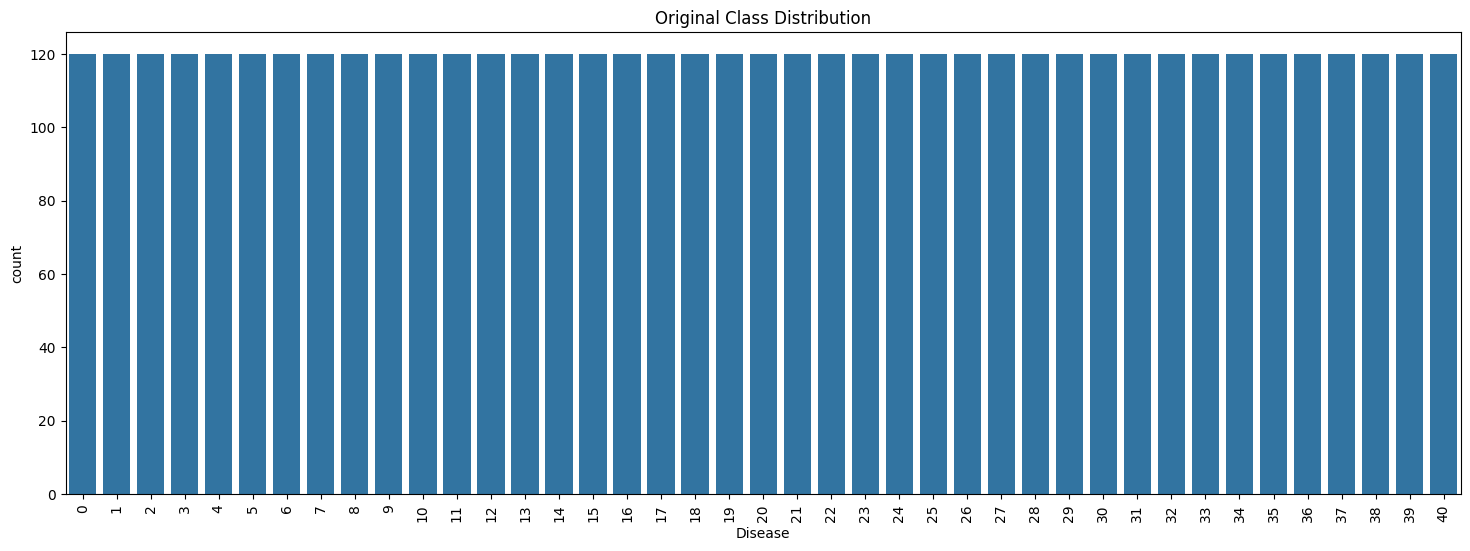

In [85]:
# ========================
# 📊 Visualize Class Distribution
# ========================
plt.figure(figsize=(18, 6))
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xticks(rotation=90)
plt.show()


In [86]:
# Define models
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
}

# Train and evaluate
model_results = train_and_evaluate(models, X_train, y_train, X_val, y_val, encoder)


🔧 Training SVM...
✅ SVM Train Accuracy: 100.00%
✅ SVM Validation Accuracy: 100.00%

🔧 Training Naive Bayes...
✅ Naive Bayes Train Accuracy: 100.00%
✅ Naive Bayes Validation Accuracy: 100.00%

🔧 Training Random Forest...
✅ Random Forest Train Accuracy: 100.00%
✅ Random Forest Validation Accuracy: 100.00%


In [87]:
# Save best models
svm_model = model_results[0]['model']
nb_model = model_results[1]['model']
rf_model = model_results[2]['model']

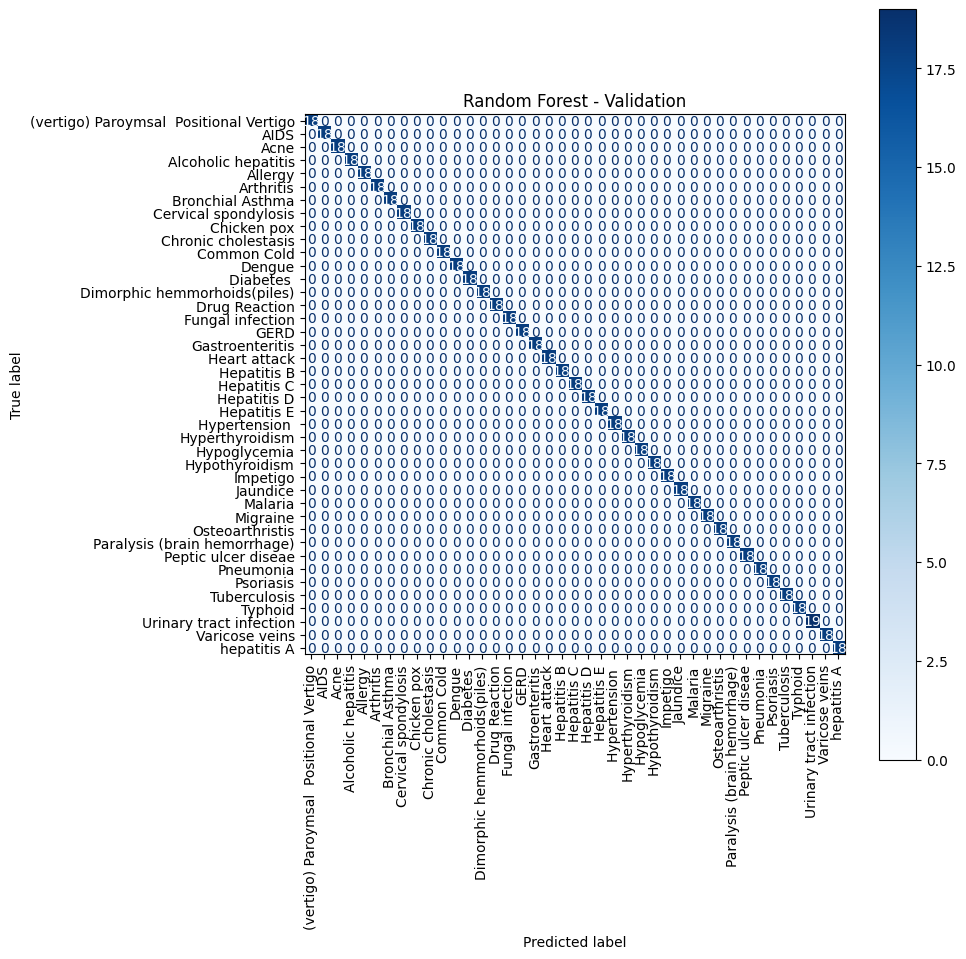

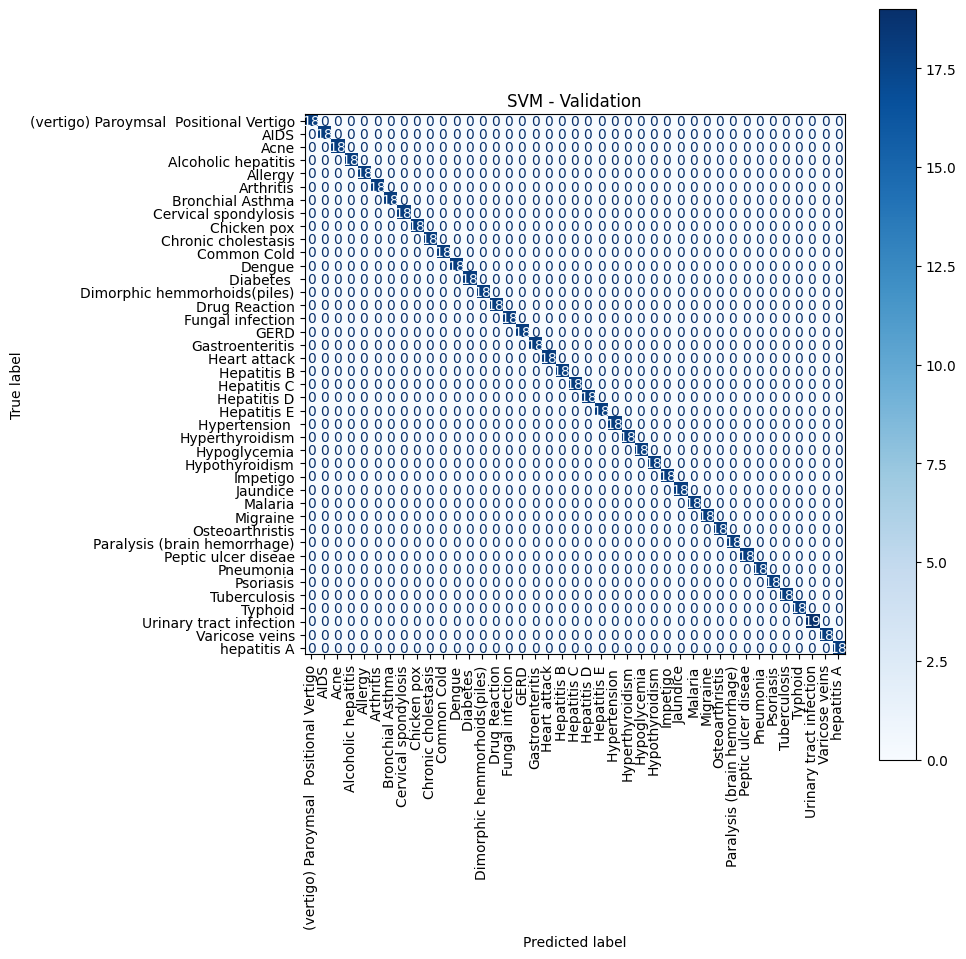

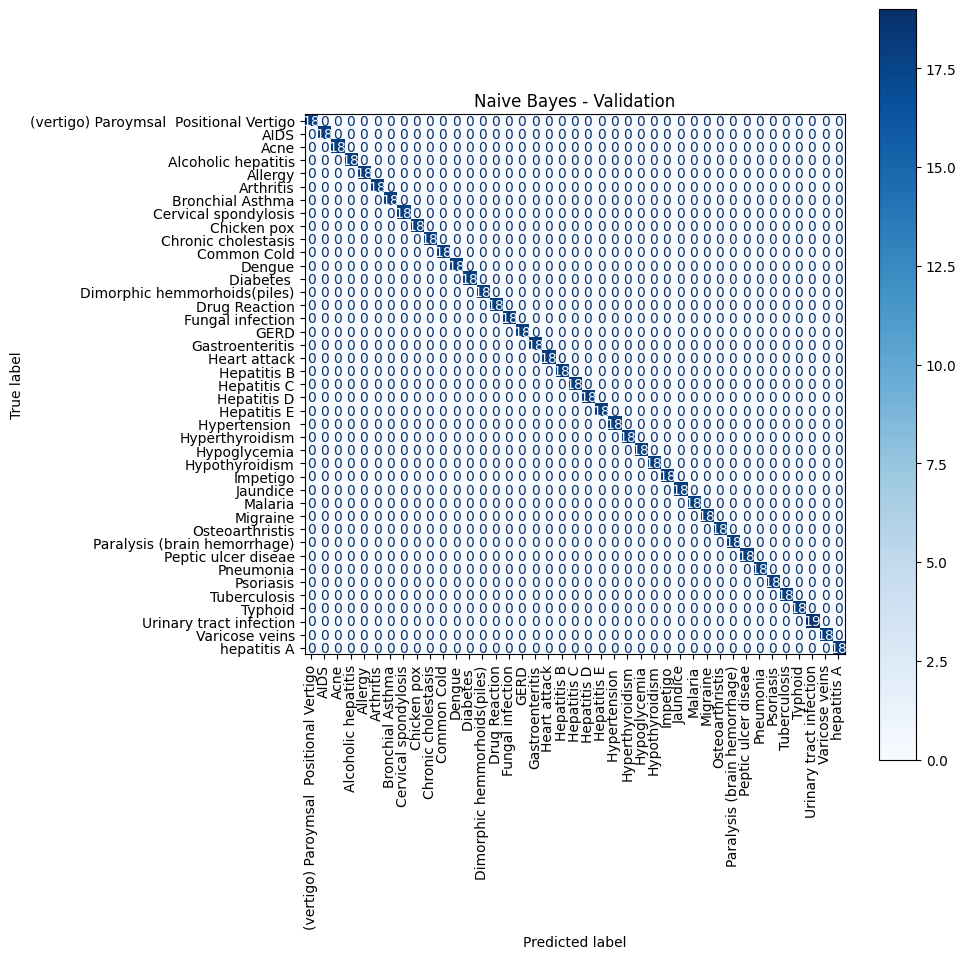

In [88]:
# ========================
# 📊 Confusion Matrix
# ========================
def plot_confusion_matrix_custom(model, X, y_true, class_labels, title="Confusion Matrix"):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix_custom(rf_model, X_val, y_val, encoder.classes_, "Random Forest - Validation")
plot_confusion_matrix_custom(svm_model, X_val, y_val, encoder.classes_, "SVM - Validation")
plot_confusion_matrix_custom(nb_model, X_val, y_val, encoder.classes_, "Naive Bayes - Validation")

In [89]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_cross_validation(model, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"📊 Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores

evaluate_cross_validation(nb_model, X_resampled, y_resampled)
evaluate_cross_validation(svm_model, X_resampled, y_resampled)
evaluate_cross_validation(rf_model, X_resampled, y_resampled)

📊 Cross-Validation Accuracy: 1.0000 ± 0.0000
📊 Cross-Validation Accuracy: 1.0000 ± 0.0000
📊 Cross-Validation Accuracy: 1.0000 ± 0.0000


array([1., 1., 1., 1., 1.])

In [90]:
# ========================
# 📋 Performance Summary
# ========================
summary_df = pd.DataFrame([{
    "Model": res["name"],
    "Train Accuracy": f"{res['train_acc']*100:.2f}%",
    "Validation Accuracy": f"{res['val_acc']*100:.2f}%"
} for res in model_results])

print("\n📊 Model Performance Summary:")
print(summary_df.to_string(index=False))


📊 Model Performance Summary:
        Model Train Accuracy Validation Accuracy
          SVM        100.00%             100.00%
  Naive Bayes        100.00%             100.00%
Random Forest        100.00%             100.00%


In [91]:
# ========================
# 🔥 Multi-Disease Prediction
# ========================
symptom_index = {symptom: idx for idx, symptom in enumerate(X.columns)}

def predict_multiple_diseases(input_symptoms):
    input_list = [0] * len(symptom_index)
    symptom_list = [s.strip().lower().replace(" ", "_") for s in input_symptoms.split(",")]
    for s in symptom_list:
        if s in symptom_index:
            input_list[symptom_index[s]] = symptom_severity.get(s.replace("_", " "), 0)
    input_df = pd.DataFrame([input_list], columns=X.columns)
    pred_rf = encoder.classes_[rf_model.predict(input_df)[0]]
    pred_nb = encoder.classes_[nb_model.predict(input_df)[0]]
    pred_svm = encoder.classes_[svm_model.predict(input_df)[0]]
    all_preds = [pred_rf, pred_nb, pred_svm]
    prediction_counts = Counter(all_preds)
    top_predictions = prediction_counts.most_common(3)
    result = []
    for disease, count in top_predictions:
        precautions = precaution_dict.get(disease, ["Not available"] * 4)
        result.append({
            "Disease": disease,
            "Votes": count,
            "Precautions": precautions
        })
    return result


In [92]:
# ========================
# 🔎 Example Prediction
# ========================
example_symptoms = "itching, skin rash, nodal skin eruptions"
results = predict_multiple_diseases(example_symptoms)

for idx, res in enumerate(results):
    print(f"Prediction #{idx+1}: {res['Disease']} (Votes: {res['Votes']}/3)")
    print("Precautions:")
    for p in res['Precautions']:
        print(f"- {p}")
    print("\n")

Prediction #1: Fungal infection (Votes: 3/3)
Precautions:
- bath twice
- use detol or neem in bathing water
- keep infected area dry
- use clean cloths




In [93]:
# ========================
# 💾 Save Models and Data
# ========================
pickle.dump(svm_model, open("svm_model.pkl", "wb"))
pickle.dump(nb_model, open("nb_model.pkl", "wb"))
pickle.dump(rf_model, open("rf_model.pkl", "wb"))
pickle.dump(encoder, open("encoder.pkl", "wb"))
pickle.dump(symptom_index, open("symptom_index.pkl", "wb"))
pickle.dump(precaution_dict, open("precaution_dict.pkl", "wb"))
